<a href="https://colab.research.google.com/github/wzhou789/FitnessBody/blob/main/SHOULDER_FITNESS_BODY_MultiInput_MultiOutput_Regression_Image_And_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SHOULDER - FitnessBody - 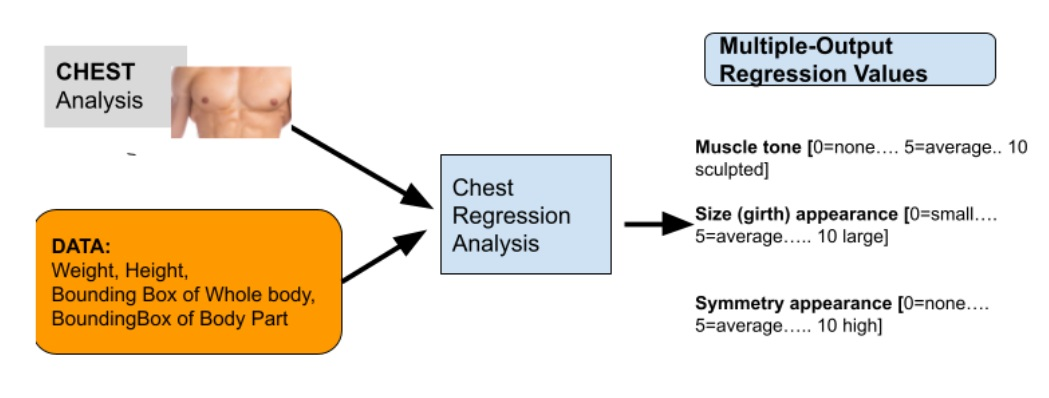Multi Input Image+Data Multi-Output Regression**



### In this colab notebook, you'll learn how to

*  Create a Multi-Input Multi-Output Regression Model.

### **Sample Model -- predicting shouldersders tone, breadth and symmetry**

***need to use linear regressor instead of logistic regressor.***!




---
---

### **Multiple Input**
*  Multiple Input = Image (partimageFilenamme)  + Data(bounding Box of whole item--in this case a person   AND bounding box of part item --in this case a specified body part like shoulders).
* xmin, ymin, xmax, ymax =  represents the bounding box of an image of a "whole" item (in this case of a person)
* xminSX, yminSX, xmaxSX, ymaxSX = represents the bounding box of an image of a "part"item (in this case a body part, like shoulders).  NOTE SX = SB to indicate for Shoulder_Breadth, the bounding box which will have the regression value of Shoulder_Breadth associated with it. SX= SS is for Shoulder_Symmetry and ST= for Shoulder_Tone.  See below step 2 for actual details of these values and how they appear in the data input

---
### **Multiple Output**
* Multiple regression outputs.  In this example, it is performed for a body part of shoulders and the regression values are "breadth", "tone" and "symmetry").
* In this example the actual values are Shoulder_Breadth, Shoulder_Symmetry, Shoulder_Tone  ---for a total of 3 regression outputs that evaluate the fitness of a user's shoulders body part.

---
## **Steps**

* **STEP 0 Mount Google Drive** this is where the data will be stored and written to
* **STEP 1 Install necessary modules and setup the Colab environment**
* **STEP 2.1 reading in a SpreadSheet** that contains data of the following format
[wholeImageFilename bbWholeX1 bbWholeY1 bbWholeX2 bbWholeY2 partImageFilename bbPartX1 bbPartY1 bbPartX2 bbPartY2 regOut1 regOut2 regOut3] --> create arrays wholeImageFileNames[] ,  partImageFilenames[],  bbWhole[], bbPart[], regOut1[], regOut2[], regOut3[]
* **STEP 2.2 sort into training and testing** arrays--> trainWholeImageFileNames[], trainpartImageFilenames[], trainbbWhole[], trainbbPart[], trainRegOut1[], trainRegOut2[]    AND  testWholeImageFileNames[], etc.
* **STEP 2.3 load images and prepocess data** create arrays trainImages[], testImages[] and validationImags[] that contain the actual images to be used for training and test.    ALSO, trainingNumericalData, testingNumericalData and validationNumericalData that contain the bounding box information for the whole body, and the shoulders (3 boxes for the 3 regression value images).  ALSO, **trainAllRegressionData**(also **testAllRegressionData & validationAllRegressionData** for test and validation data)  = numpy array of arrays = [[SB1, SS1, ST1], [SB2, SS2, ST2], ....]    where SBi = Shoulder_Breadth regression value for sample i, SSi = Shoulder_Symmetry for sample i,  STi = Shoulder_Tone for sample i.    An example:

```
[[5. 3. 5.]
 [5. 5. 4.]
 [3. 5. 3.]
 [3. 5. 5.]
 [9. 7. 7.]
 [3. 7. 7.]
 [5. 5. 5.]
 [5. 5. 5.]]
```
***CURRENTLY do not normalize data --may do in the future***
* **STEP 3 define the model** using Tensorflow and concatenate define the Multi-Input and Multi-Output model (see https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ for an example).
* **STEP 4 train the model**  This will include a CNN pre-trained pre-existing Feature Extractor (CNN without the last layers).   Then this connects to incomming data (bounding box info) using Concatenate and this is passed to a Fully Connected network.  The output layer will be the 3 regression output values.
*  **STEP 5 test the model**


---
## **TRAINING + TESTING**
train a custom image regression model from a pre-existing model
*  tune parameters
*  evaluate it
*  run test cases and plot results
*  run tensorboard
*  save it to Saved_Model
*  export as TFLite




---
## **About Regression Training In General**

How is this done:  
*   The only difference from classification the metric for loss ---see below is where mean_absolute_errror is used and in our case the final output layer has a cardinality of 1  (which represents "severity" our target regression value)


```
 model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
```

*  Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).



References:
* https://www.tensorflow.org/tutorials/keras/regression
* https://rosenfelder.ai/keras-regression-efficient-net/


# **Expected Data**



*   images_dir = directory containing  the images both the whole and body part (shoulders) images as well as the csv file
*   annotationsSingleLine.csv = a CSV file containing the following columns:
wholeimage, xmin,ymin,xmax,ymax,filenameSB (part image for Shoulder_Breadth), Shoulder_Breadth regression,xminSB,yminSB,xmaxSB,ymaxSB, filenameSS (part image for Shoulder_Symmetry), Shoulder_Symmetry regression,xminSS,yminSS,xmaxSS,ymaxSS, filenameST (part image for Shoulder_Tone), Shoulder_Tone regression,xminST,yminST,xmaxST,ymaxST,

WHERE the Shoulder_Breadth, Shoulder_Symmetry and Shoulder_Tone are the output regression values ranging
in our case from 0 to 10

**NOTE: X is the column (width direction of image) and Y is the row (height direction of image)**

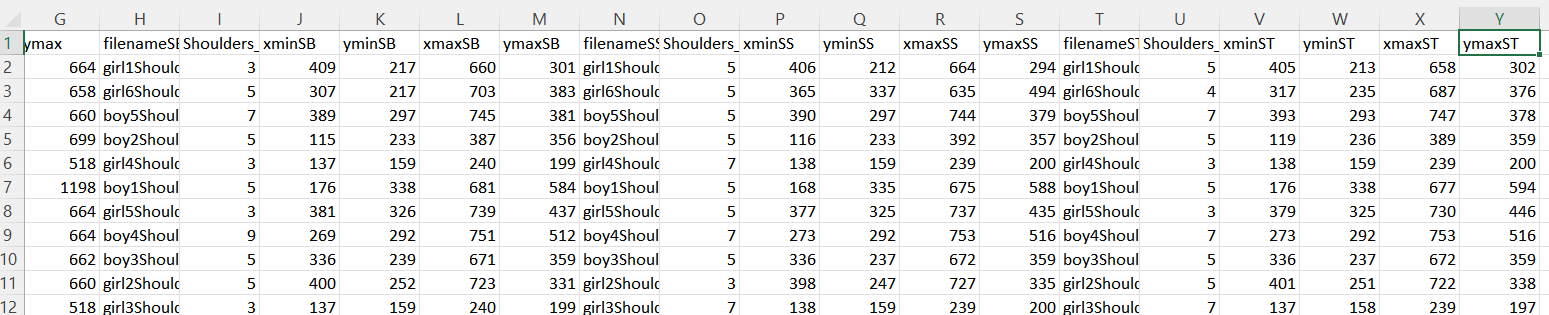

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# STEP 0: mount Drive and install libraries and import packages

### assumes data in drive/Mask/MaskDetect/data


Here you'll use the dataset given in the zip file (http://borg.csueastbay.edu/~grewe/CS663/Mat/TensorFlow/TensorFlowLiteModelMaker/data.zip).

*  grab the zip and unzip and upload the content to your drive in the path YOUDRIVE/Mask/MaskDetect

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## STEP 1:  SETUP

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

## Select the TF2 SavedModel module to use & specify BATCH_SIZE, determine IMAGE_SIZE to allign with model input size

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [ ]:
#@title

model_name = "efficientnetv2-b0" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 4 #@param {type:"integer"}
print(f"Batch size {BATCH_SIZE}")

#  STEP 2:  Set up the  dataset



## **For now will hardcode the data**

## Step 2.1 : read in the regressionData.csv file that contains in csv format:
 wholeimage, xmin,ymin,xmax,ymax,filenameSB (part image for Shoulder_Breadth), Shoulder_Breadth regression,xminSB,yminSB,xmaxSB,ymaxSB, filenameSS (part image for Shoulder_Symmetry), Shoulder_Symmetry regression,xminSS,yminSS,xmaxSS,ymaxSS, filenameST (part image for Shoulder_Tone), Shoulder_Tone regression,xminST,yminST,xmaxST,ymaxST, using [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Iterator, List, Union, Tuple, Any

In [ ]:
#i_dir = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/train"
i_dir = "drive/MyDrive/shared/train/shoulder_imgs"
!ls $i_dir

In [ ]:
#image_dir= "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/train"
#main_dir =  "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/"
#log_dir = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/tensorboard/"
image_dir = "drive/MyDrive/shared/train/shoulder_imgs"
main_dir = "drive/MyDrive/shared/train/"
log_dir = "drive/MyDrive/shared/regression/tensorboard"
print("image_dir\n")

print(image_dir)
!ls $image_dir
print("main_dir\n")
!ls $(main_dir)
print("log_dir\n")
!ls $log_dir

#dataFile = image_dir + "/annotationsSingleLine.csv"
dataFile = image_dir + "/shouldersCSV.csv"
!cat $dataFile


In [ ]:
#open a csv file with pandas
pandasDataFrame = pd.read_csv(dataFile)
print(pandasDataFrame)

In [ ]:
print(pandasDataFrame['filenameSB'])
print(pandasDataFrame['Shoulder_Breadth'])

In [ ]:
# add the correct path for the image locations.
pandasDataFrame["filenameSB"] = (
        image_dir + "/" + pandasDataFrame["filenameSB"]
    )
pandasDataFrame["filenameSS"] = (
        image_dir + "/" + pandasDataFrame["filenameSS"]
    )
pandasDataFrame["filenameST"] = (
        image_dir + "/" + pandasDataFrame["filenameST"]
    )

In [ ]:
for x in pandasDataFrame["filenameSB"]:
  print(x)

## Step 2.2 split the pandas DataFrame (just arrays of image filenames and severities) into train, test, validation.   Uses [train_test_split() from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)



*  [ pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) api




In [ ]:
from sklearn.model_selection import train_test_split
#testAndValid_percent = 0.4  #as decimal percentange of data to form test+valid
testAndValid_percent = 0.2
test_valid_split_percent = 0.5 #as a decimal the percentage of the test+valid data to test data

def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.

    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val_test = train_test_split(df, test_size=testAndValid_percent, random_state=1)  # split the data with a validation size of train_valid_percent
    val, test = train_test_split( val_test, test_size=test_valid_split_percent, random_state=1)  # split the valid and test data by percent specified above

    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore
    print("shape test: ", test.shape)  # type: ignore

    print("Descriptive statistics of train:")
    print(train.describe())  # type: ignore
    return train, val, test  # type: ignore


#use function above to split into train test, validation
train, val, test = split_data(pandasDataFrame)

#see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html  for documentation on DataFrames in Pandas

#print out lengths
print("LENGTH:  train test valid:  " + str(len(train)) + ", " + str(len(test)) + ", " + str(len(val)))


#print out data

print("train")
for index, row in train.iterrows():
    print(row["filenameSB"], row["Shoulder_Breadth"])

print("\n\n test")
for index, row in test.iterrows():
    print(row["filenameSB"], row["Shoulder_Breadth"])

print("\n\n valid")
for index, row in val.iterrows():
    print(row["filenameSB"], row["Shoulder_Breadth"])

print("\n\nshape train: ", train.shape)  # type: ignore
print("shape val: ", val.shape)  # type: ignore
print("shape test: ", test.shape)  # type: ignore

print("\n\nDescriptive statistics of test:")
print(test.describe())  # type: ignore


print(train.info)
print(train.iteritems)
print(train.itertuples)


##STEP 2.3 create numpy arrays of images and corresponding arrays of regression outputs (Shoulder_Breadth, Shoulder_Symmetry, Shoulder_Tone) using pandas DataFrame


### Step 2.3.1 load and resize images for training, testing and validation & load Regression values in corresponding order



*   ***input*** = pandas DataFrames train, test, val containing columns "filename" and "severity"

*   ***output*** = ***trainImages,testImage, validationImages*** :  **DICTIONARIES** of loaded images that are resized to IMAGE_SIZE (e.g. 224,224 )

*   ***output*** = ***trainShoulder_Breadth, trainShoulder_Symmetry, trainShoulder_Tone, testShoulder_Breadth, testShoulder_Symmetry, testnShoulder_Tone, validationShoulder_Breadth, validationShoulder_Symmetry, validationShoulder_Tone***,: **NUMPY ARRAYS** of corresponding regrestion values for the trainImages, testImages, etc.

*   ***output*** = **trainNumericData,testNumericData,validationNumericData** = **NUMPY ARRAYS** containing all of the numeric data which in this example are the bounding boxes of the whole person, and bounding boxes for the 3 regression values of Shoulder_Breadth, Shoulder_Symmetry and Shoulder_Tone for the training, testing and validaton data respectively


## **<mark>IMPORTANT NOTE</mark>**:  I take the image from Shoulder_Breadth as the image to use for the body part,  I don't want all three.**POTENTIAL ISSUE**by choosing one image it could be that other bounding boxes outside this image however, as long as I am not trying to do any drawing with this bounding box that is fine.  





In [ ]:
#PROCESS TRAINING DATA
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
import PIL

#toggle betwee True and False if want to plot images + show info that are read in
showInfo = True

#first define as dictionaries and lists as they can grow dynamically unlike arrays.
trainImages = {}  #define as  a dictionary
trainShoulder_Breadth =  [] #define as lists
trainShoulder_Symmetry = []
tempList = []
trainShoulder_Tone = []
trainNumericData = []

i=0
newsize = (IMAGE_SIZE, IMAGE_SIZE)

print("TRAIN Images")
for index, row in train.iterrows():
    trainShoulder_Breadth.append(row["Shoulder_Breadth"])
    trainShoulder_Symmetry.append(row["Shoulder_Symmetry"])
    trainShoulder_Tone.append(row["Shoulder_Tone"])
    list = [row["xmin"], row["ymin"], row["xmax"], row["ymax"],
                    row["xminSB"], row["yminSB"], row["xmaxSB"], row["ymaxSB"],
                    row["xminSS"], row["yminSS"], row["xmaxSS"], row["ymaxSS"],
                    row["xminST"], row["yminST"], row["xmaxST"], row["ymaxST"]]
    print(list)
    trainNumericData.append(np.array(list));

    img = row["filenameSB"]    #POTENTIAL ISSUE by choosing one image it could be that other bounding boxes outside this image
   # ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    trainImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    if showInfo : plt.imshow(trainImages[i])
    if showInfo : plt.xlabel("(b,s,t)= (" + str(trainShoulder_Breadth[i]) + "," + str(trainShoulder_Symmetry[i]) + "," + str(trainShoulder_Tone[i]) +")")
    if showInfo : plt.show()
    i = i+1

if showInfo : plt.close()

#convert lists to numpy arrays
print("trainShoulder_Breadth before conversion")
print(trainShoulder_Breadth)

print("trainShoulder_Breadth AFTER conversion")
trainShoulder_Breadth = np.fromiter(trainShoulder_Breadth, dtype=np.float32)
print(trainShoulder_Breadth)
trainShoulder_Symmetry = np.fromiter(trainShoulder_Symmetry, dtype=np.float32)
trainShoulder_Tone = np.fromiter(trainShoulder_Tone, dtype=np.float32)

print("Before Convert trainNumericData --still a list")
print(trainNumericData)
print("After Converstion trainNumericData to a numpy array")
trainNumericData = np.array(trainNumericData)
print(trainNumericData)

In [ ]:
#PROCESS TESTING DATA
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
import PIL



#toggle betwee True and False if want to plot images + show info that are read in
showInfo = False #True

#define as dictionaries and lists so can dynamically gropu
testImages = {}  #define as  a dictionary
testShoulder_Breadth =  [] #define as lists
testShoulder_Symmetry = []
tempList = []
testShoulder_Tone = []
testNumericData = []

i=0
newsize = (IMAGE_SIZE, IMAGE_SIZE)

print("TEST Images")
for index, row in test.iterrows():
    testShoulder_Breadth.append(row["Shoulder_Breadth"])
    testShoulder_Symmetry.append(row["Shoulder_Symmetry"])
    testShoulder_Tone.append(row["Shoulder_Tone"])
    #list = [row["xmin"], row["ymin"], row["xmax"], row["ymax"],
    #injection --wendy
    data_list = [row["xmin"], row["ymin"], row["xmax"], row["ymax"],
                    row["xminSB"], row["yminSB"], row["xmaxSB"], row["ymaxSB"],
                    row["xminSS"], row["yminSS"], row["xmaxSS"], row["ymaxSS"],
                    row["xminST"], row["yminST"], row["xmaxST"], row["ymaxST"]]
    print(data_list)
    testNumericData.append(np.array(data_list));  #convert the list to numpy array before adding

    img = row["filenameSB"]    #POTENTIAL ISSUE by choosing one image it could be that other bounding boxes outside this image
   # ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    testImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    if showInfo : plt.imshow(testImages[i])
    if showInfo : plt.xlabel("(b,s,t)= (" + str(testShoulder_Breadth[i]) + "," + str(testShoulder_Symmetry[i]) + "," + str(testShoulder_Tone[i]) +")")
    if showInfo : plt.show()
    i = i+1

if showInfo : plt.close()

#convert lists to numpy arrays
print("testShoulder_Breadth before conversion")
print(testShoulder_Breadth)

print("testShoulder_Breadth AFTER conversion")
testShoulder_Breadth = np.fromiter(testShoulder_Breadth, dtype=np.float32)
print(testShoulder_Breadth)
testShoulder_Symmetry = np.fromiter(testShoulder_Symmetry, dtype=np.float32)
testShoulder_Tone = np.fromiter(testShoulder_Tone, dtype=np.float32)

print("Before Convert testNumericData --still a list")
print(testNumericData)
print("After Converstion testNumericData to a numpy array")
testNumericData = np.array(testNumericData)
print(testNumericData)

In [ ]:
#PROCESS VALIDATION DATA
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
import PIL

#set True to display images + infor or False if not
showInfo = True

#define as lists and dictionaries so can grow dynamically, convert to numpy arrays at end
validationImages = {}  #define as  a dictionary
validationShoulder_Breadth =  [] #define as lists
validationShoulder_Symmetry = []
tempList = []
validationShoulder_Tone = []
validationNumericData = []

i=0
newsize = (IMAGE_SIZE, IMAGE_SIZE)

print("VALIDATION Images")
for index, row in val.iterrows():
    validationShoulder_Breadth.append(row["Shoulder_Breadth"])
    validationShoulder_Symmetry.append(row["Shoulder_Symmetry"])
    validationShoulder_Tone.append(row["Shoulder_Tone"])
    list = [row["xmin"], row["ymin"], row["xmax"], row["ymax"],
                    row["xminSB"], row["yminSB"], row["xmaxSB"], row["ymaxSB"],
                    row["xminSS"], row["yminSS"], row["xmaxSS"], row["ymaxSS"],
                    row["xminST"], row["yminST"], row["xmaxST"], row["ymaxST"]]
    print(list)
    validationNumericData.append(np.array(list));

    img = row["filenameSB"]    #POTENTIAL ISSUE by choosing one image it could be that other bounding boxes outside this image
   # ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
    validationImages[i]=np.array(PIL.Image.open(img).resize(IMAGE_SIZE))
    if showInfo : plt.imshow(validationImages[i])
    if showInfo : plt.xlabel("(b,s,t)= (" + str(validationShoulder_Breadth[i]) + "," + str(validationShoulder_Symmetry[i]) + "," + str(validationShoulder_Tone[i]) +")")
    if showInfo : plt.show()
    i = i+1

if showInfo : plt.close()

#convert lists to numpy arrays
print("validationShoulder_Breadth before conversion")
print(validationShoulder_Breadth)

print("validationShoulder_Breadth AFTER conversion")
validationShoulder_Breadth = np.fromiter(validationShoulder_Breadth, dtype=np.float32)
print(validationShoulder_Breadth)
validationShoulder_Symmetry = np.fromiter(validationShoulder_Symmetry, dtype=np.float32)
validationShoulder_Tone = np.fromiter(validationShoulder_Tone, dtype=np.float32)

print("Before Convert validationNumericData --still a list")
print(validationNumericData)
print("After Converstion validationNumericData to a numpy array")
validationNumericData = np.array(validationNumericData)
print(validationNumericData)

/content/drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/train/gril6Shoulder.jpg

### **Step 2.3.2  package images into numpy arrays of 2D numpy arrays  for input for training, validation and testing**



*  input =  trainImages,testImages & validationImages , dictionaries of images
*  ouptupt = nparrays of float32 called trainImageData, testImageData and validationImageData

#### **NOTE:**
* EfficientNet expects int as input, as it automatically does the conversion to float and rescale to 0-1.0 see https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

* HOWEVER my model below puts an input layer in front of the EfficientNEt model so that takes as input float32 values by default so in this block I convert to float32 only.  


In [ ]:
#convert image dictionaries into numpy array of 2D arrays
trainImageData = np.array([each for each in trainImages.values()]).astype(np.float32)
validationImageData = np.array([each for each in validationImages.values()]).astype(np.float32)
testImageData = np.array([each for each in testImages.values()]).astype(np.float32)

In [ ]:
print("number train images " + str(trainImageData.shape[0]))
print(trainImageData)

### **Step 2.3.2  package regression value arrays into float based numpy arrays for input numerical data for training, validation and testing**



*  input =  trainShould_Breadth(,testShoulder_Breadth & validationShoulder_Breadth, ETC.(Symmetry and Tone too) as Numpy Arrays of Ints
*  ouptupt = nparrays of float32 called trainShoulder_Breadth, testSeverity and validationSeverity (Symmetry and Tone too)
*  output = **trainAllRegressionData**(also testAllRegressionData & validationAllRegressionData for test and validation data)  = an array of arrays = [[SB1, SS1, ST1], [SB2, SS2, ST2], ....]    where SBi = Shoulder_Breadth for sample i, SSi = Shoulder_Symmetry for sample i,  STi = Shoulder_Tone for sample i.    An example:

```
[[5. 3. 5.]
 [5. 5. 4.]
 [3. 5. 3.]
 [3. 5. 5.]
 [9. 7. 7.]
 [3. 7. 7.]
 [5. 5. 5.]
 [5. 5. 5.]]
```



In [ ]:
#now setup train and test arrays to be nparrays of float32 from the *Shoulder_Breadth,*Shoulder_Symmetry, *Shoulder_Tone (i.e. trainShoulder_Breadth) from numpy arrays created above

trainShoulder_Breadth = np.fromiter(trainShoulder_Breadth, dtype=np.float32)
print(trainShoulder_Breadth)
trainShoulder_Symmetry = np.fromiter(trainShoulder_Symmetry, dtype=np.float32)
print(trainShoulder_Symmetry)
trainShoulder_Tone = np.fromiter(trainShoulder_Tone, dtype=np.float32)
print(trainShoulder_Tone)

#now for test data
testShoulder_Breadth = np.fromiter(testShoulder_Breadth, dtype=np.float32)
print(testShoulder_Breadth)
testShoulder_Symmetry = np.fromiter(testShoulder_Symmetry, dtype=np.float32)
print(testShoulder_Symmetry)
testShoulder_Tone = np.fromiter(testShoulder_Tone, dtype=np.float32)
print(testShoulder_Tone)


#now for validation data
validationShoulder_Breadth = np.fromiter(validationShoulder_Breadth, dtype=np.float32)
print(validationShoulder_Breadth)
validationShoulder_Symmetry = np.fromiter(validationShoulder_Symmetry, dtype=np.float32)
print(validationShoulder_Symmetry)
validationShoulder_Tone = np.fromiter(validationShoulder_Tone, dtype=np.float32)
print(validationShoulder_Tone)


#Now create single array where each element has the regression values {Shoulder_Breadth, Shoulder_Symmetry, Shoulder_Tone}
# in that order using numpy.stack
trainAllRegressionData = np.stack((trainShoulder_Breadth, trainShoulder_Symmetry,trainShoulder_Tone), axis=1)
print("train ALL Regression Data as a numpy array")
print(trainAllRegressionData)

testAllRegressionData = np.stack((testShoulder_Breadth, testShoulder_Symmetry,testShoulder_Tone), axis=1)
print("test ALL Regression Data as a numpy array")
print(testAllRegressionData)

validationAllRegressionData = np.stack((validationShoulder_Breadth, validationShoulder_Symmetry,validationShoulder_Tone), axis=1)
print("validation ALL Regression Data as a numpy array")
print(validationAllRegressionData)


### **Step 2.3.3   (optional) Scale the float numpy input numerical data for training, validation and testing**



*  ***inpuput*** = **trainNumericData,testNumericData,validationNumericData** = **NUMPY ARRAYS** containing all of the numeric data which in this example are the bounding boxes of the whole person, and bounding boxes for the 3 regression values of Shoulder_Breadth, Shoulder_Symmetry and Shoulder_Tone for the training, testing and validaton data respectively
*. ***input*** = width, height of original image.  
*  ***output*** = **trainNumericData,testNumericData,validationNumericData** = **SCALED NUMPY ARRAYS**
*  NOTE:  X values are columns (width direction, and Y values are rows(height direction).
* SCALING = x = (float) x/width and y =(float)y/height

```
suppos x y x y.  and width =300 and height =500
[100 250 2250 300 ....] ->  [0.333 0.5 0.75 1.0
```



In [ ]:
print(trainNumericData)

In [ ]:
for i in range(0, 10, 2):
   print(i)

In [ ]:
for trainNumDataSample in trainNumericData:
   print(trainNumDataSample)


   for i in range(0, len(trainNumDataSample), 2):
     print(" should be an x value " + str(trainNumDataSample[i]))
     print(" should be a y value " +str(trainNumDataSample[i+1]))

In [ ]:
# cycle through the numpy array for training an scale by the width and hieght
print("Width")
trainWidths = pandasDataFrame['width']
print(pandasDataFrame['width'])
print("Height")
trainHeights = pandasDataFrame['height']
print(pandasDataFrame['height'])

print("before")
print(trainNumericData)


for trainWidth, trainHeight, trainNumDataSample  in zip(trainWidths, trainHeights, trainNumericData):
  for i in range(0,len(trainNumDataSample), 2): #cycling through the 1D numpy array for a particiular train image
      #first sample is X
      trainNumDataSample[i] = trainNumDataSample[i]/trainWidth
      #second sample is Y
      trainNumDataSample[i+1] = trainNumDataSample[i+1]/trainHeight

print("after")
print(trainNumericData)

# **STEP 3: *Defining* the model**

**All it takes is to put a SINGLE dense layer (1D for output predictions from regression) on top of the `feature_extractor_layer` with the Hub module.**

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.


This is the model that will will create - One input is the image and the other is the numeric data input in the following order:

*  (**4x4=12 elements**):
1.   bounding box whole person,
2.   bounding box for Shoulder_Breadth,
3.   bounding box for Shoulder_Symmetry
4.   bounding box for Shoulder_Tone

= *{xmin, ymin, xmax, ymax, xminSB, yminSB, xmaxSB,ymaxSB, xminSS, yminSS, xmaxSS, ymaxSS, xminST, yminST, xmaxST, ymaxST}*
*   where SB = indicates for Shoulder_Breadth, SS= indicates for ShoulderSymmetry, ST = indicates for ShoulderTone

[Watch the Video Discussing the Model Below](https://youtu.be/ybfSWcUvJaA)

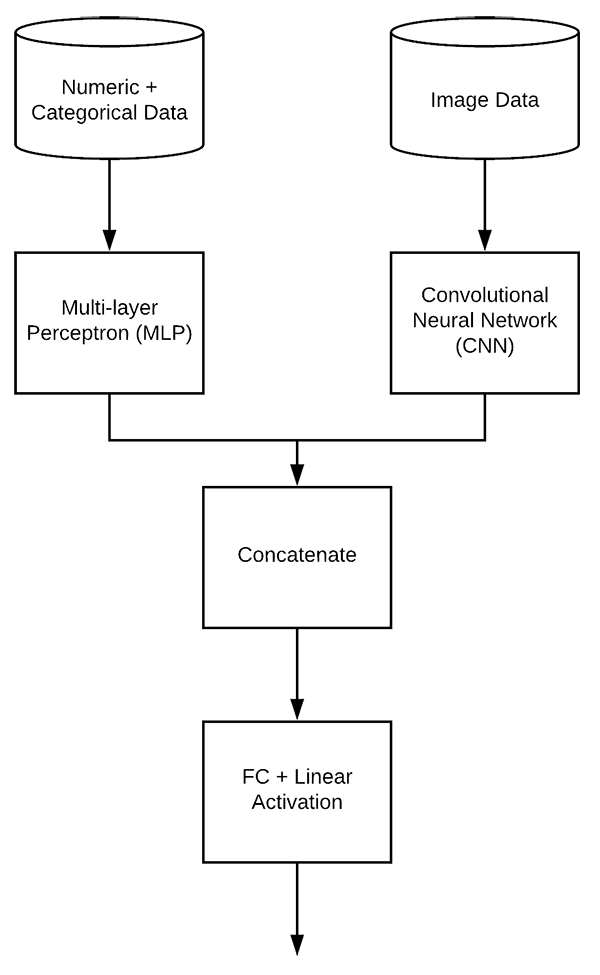

In [ ]:
#TOGGLE This if you want to have the CNN layers be trainable or not
do_fine_tuning = True #@param {type:"boolean"}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate

## **Step 3.1 Define function to create the DataProcessing Branch dataMLP**

In [ ]:
#define the dimension of input data
data_order={"xmin","ymin","xmax","ymax","xminSB","yminSB","xmaxSB","ymaxSB","xminSS","yminSS","xmaxSS","ymaxSS","xminST","yminST","xmaxST","ymaxST"}
data_dimension = len(data_order)
print(" THE read in data length of first sample =" + str(len(trainNumericData[0])))
print("data dimension is "+ str(data_dimension))
print("data order is =")
print(data_order)

print("\n\n\n\n")

output_order={"Shoulder_Breadth", "Shoulder_Symmetry", "Shoulder_Tone"}
output_dimension = len(output_order)
print(" Length of first sample  trainAllRegressionData[0] =" + str(len(trainAllRegressionData[0])))
print("output dimension is " + str(output_dimension))
print(output_order)

In [ ]:
#this is the part of the model network for the Data prior to concatenation

def create_dataMLP(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))
	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))
	# return our model
	return model



## **Step 3.2 Define function to create the ImageProcessing Branch imageCNN**

In [ ]:
def create_imageCNN():
	#define model as the first part (no decision layer) of the specified model_handle --like EfficientDet
  # that is pretrained with the corresponding  IMAGE_SIZE
  #  also the option above do_fine_tuning determines if model will be trainable or fixed.
  model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),  #dtype	Optional datatype of the input. When not provided, the Keras default float type will be used.
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    #tf.keras.layers.Dropout(rate=0.2),
    #tf.keras.layers.Dense(1, name="pred")    #, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
   ])
  return model



## **Step 3.3 create function and run it to create and concatenate a data model_dataMLP and an image imageCNN into a single multi-input model with multiple output regression values of Shoulder_Breadth, Shoulder_Symmetry and Shoulder_Tone**

In [ ]:
#FUNCTION to create the model
def create_MultiInputMultiOutputRegressionModel():
  #
  # create the MLP and CNN models

  #first create the dataMLP model
  model_dataMLP = create_dataMLP(data_dimension)
  print("DATA MLP model branch")
  model_dataMLP.summary()


  #next create the imageCNN model

  print("\n\n----------------------")
  model_imageCNN = create_imageCNN()
  print("IMAGE CNN model branch")
  model_imageCNN.summary()
  print("\n\n\n\n----------------------")

  # create the input to our final set of layers as the *output* of both
  # the mode_dataMLP and mode_imageCNN
  combinedInput = concatenate([model_dataMLP.output, model_imageCNN.output])


  #CREATE the fully connected network after the concatenation
  # our final FC layer head will have two dense layers, the final one
  # being our regression head which has dimension of output_dimension
  #x = Dense(4, activation="relu")(combinedInput)
  x = Dense(128, activation="relu")(combinedInput)
  # LYNNE ADD A DROPOUT LAYER
  x =tf.keras.layers.Dropout(rate=0.2)(x)
  x = Dense(32, activation="relu")(x)
  # LYNNE ADD A DROPOUT LAYER
  x =tf.keras.layers.Dropout(rate=0.2)(x)
  x = Dense(output_dimension, activation="linear", name="pred")(x)



  # our final model will accept categorical/numerical data on the MLP
  # input and images on the CNN input, outputting a single value (the
  # predicted price of the house)
  model = Model(inputs=[model_dataMLP.input, model_imageCNN.input], outputs=x)




  print("COMPLETE Multi-Input Multi-Output Model")
  model.summary()
  return model


In [ ]:
#CREATE THE MODEL
model = create_MultiInputMultiOutputRegressionModel()


#  **STEP 4: Training the model for regression**


from https://rosenfelder.ai/keras-regression-efficient-net/
**use loss mean_absolute_error !!!**


```
model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
```



## Setup Checkpoint saving for model and Compile

<mark>IMPORTANT:  update the checkpoint_dir each time you do a different training run or copy over old checkpoints to different saved directory and clear it out</mark>

In [ ]:
#Model Compile and setup with checkpoint call back

#def compileSetupModel(model, checkpoint_dir = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/checkpoints/Run2"):
def compileSetupModel(model, checkpoint_dir = "drive/MyDrive/shared/regression/tensorboard"):
  #from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageErr

  print("Contents of checkpoints directory ")
  !ls $checkpoint_dir
  #setup the  loss as MeanAbsoluteError() so will do regression
  model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss = tf.keras.losses.MeanAbsoluteError())

  # there is some issue with being able to  reload the model from a saved_model if MeanAbsolute Error is
  #  used as a metric or MeanSquaredError  so commenting this out so can save model and reload it.
  #  see below STEP 13 for information about this.   Also our lossis MeanAbsoluteError so this is already tracked.
  # metrics=[ MeanAbsoluteError()])  #, MeanAbsolutePercentageError() do not use as we have 0 value in our data

  #  recall above for  Classification  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),





#call the function above to compile/setup the model
compileSetupModel(model)

In [ ]:
#JUST printing out some size information for Diagnostic info
train_size = len(trainImages)
print("TRAIN")
print(train_size)
print("corresponding Shoulder_Breadth size =" + str(len(trainShoulder_Breadth)))
print("corresponding trainAllRegressionData size =" +str(len(trainAllRegressionData)))

print("\n\nVAL")
val_size = len(validationImages)
print(val_size)
print("corresponding Shoulder_Breadth size =" +str(len(validationShoulder_Breadth)))
print("corresponding validationAllRegressionData size =" +str(len(validationAllRegressionData)))

## <mark>IMPORTANT:  move any previous Run Tensorboard files before retraining if you want to keep as different runs and be clear what files belong to which training run</mark>




In [ ]:
#SAFTEY CHECK

#FIRST TRAINING DATA
#print out info about inputs
print("trainNumericData length=" +str(len(trainNumericData)))
print("trainImageData length=" +str(len(trainImageData)))
print("trainAllRegressionData length=" +str(len(trainAllRegressionData)))
#print out shape about inputs
print("trainNumericData shape=" +str(trainNumericData.shape))
print("trainImageData shape=" +str(trainImageData.shape))
print("trainAllRegressionData shape=" +str(trainAllRegressionData.shape))


#Saftey -check if all inputs and outputs are numpy arrays
if isinstance(trainNumericData, np.ndarray):
    print("trainNumericData is a numpy array")
else:
    print("trainNumericData is NOT a numpy array")
if isinstance(trainImageData, np.ndarray):
    print("trainImageData is a numpy array")
else:
    print("trainImageData is NOT a numpy array")
if isinstance(trainAllRegressionData, np.ndarray):
    print("trainALlRegressionData is a numpy array")
else:
    print("trainAllRegressionData is NOT a numpy array")



#SECOND VALIDATION DATA
#print out info about inputs
print("validationNumericData length=" +str(len(validationNumericData)))
print("validationImageData length=" +str(len(validationImageData)))
print("trainAllRegressionData length=" +str(len(validationAllRegressionData)))
#print out shape about inputs
print("validationNumericData shape=" +str(validationNumericData.shape))
print("validationImageData shape=" +str(validationImageData.shape))
print("validationAllRegressionData shape=" +str(validationAllRegressionData.shape))


#Saftey -check if all inputs and outputs are numpy arrays
if isinstance(validationNumericData, np.ndarray):
    print("validationNumericData is a numpy array")
else:
    print("validationNumericData is NOT a numpy array")
if isinstance(trainImageData, np.ndarray):
    print("validationImageData is a numpy array")
else:
    print("validationImageData is NOT a numpy array")
if isinstance(validationAllRegressionData, np.ndarray):
    print("validationALlRegressionData is a numpy array")
else:
    print("validationAllRegressionData is NOT a numpy array")

### File naming convention of checkpoints --FYI



```
# In ModelCheckpoint, formatted name of filepath argument, can only be contain: epoch + keys in logs after epoch ends.

You can see available keys in logs like this:

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Log keys: {}".format(keys))

model.fit(..., callbacks=[CustomCallback()])
If you run code above, you will see something like this:

Log keys: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Which shows you available keys you can use (plus epoch) and lr is not available for you (You have used 3 keys: epoch, lr and val_loss in filepath name).

```





In [ ]:
# Train using numpy arrays trainImages, train["severity"]  and validationImages, val["severity"]
# see https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow
# see model.fit

train_size = len(trainImages)
valid_size = len(validationImages)
print("Length of validationImageData" + str(len(validationImageData)))
steps_per_epoch = (train_size // BATCH_SIZE)-1
validation_steps = (valid_size // BATCH_SIZE)-1 #odd error asking for huge number of batches if we don't do this

#Saftey check --minimum steps is 1
if(steps_per_epoch < 1):
  steps_per_epoch = 1
  print("ERROR: you can NOT traing with less than 1 steps_per_epoch")
if(validation_steps < 1):
  validation_steps= 1
  print("ERROR: you can NOT have validation data with less than 1 steps_per_epoch")

print("steps_per_epoch ="+str(steps_per_epoch))
print("validation_steps ="+str(validation_steps))


epochs = 376  #should be more like 1000

print("Steps per epoch for training is "+ str(steps_per_epoch))
# train the model
print("[INFO] training model...")

# see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
#checkpoints_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Classifier-4Classes/checkpoints/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5""
#  save every 5 epochs
#for more on checkpoints also see this blog https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6


checkpoint_dir = "drive/MyDrive/shared/regression/tensorboard"
checkpoint_dir = checkpoint_dir + "/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5"
#checkpoint_dir = checkpoint_dir + "/checkpoint-{epoch:02d}.hdf5"
mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, monitor='val_loss', save_best_only=True, verbose=1, save_freq='epoch')   # save_weights_only=True


#callback for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)


#(optional) early stopping callback (maybe) https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) #stop after 10 consecutive times val_loss not decreasing



# WORKS as everything is numpy arrays.... I think
hist = model.fit(
    x=[trainNumericData, trainImageData],   #x=trainImages,    # images
    y=trainAllRegressionData,  #y=train["severity"],  # severity target regression value
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=([validationNumericData, validationImageData], validationAllRegressionData),
    #Even though the validation steps is not 0, it will not calculate validation steps when specified
    #validation_steps=validation_steps,
    validation_freq=1,
    #callbacks=[mc, tensorboard_callback,earlyStop_callback]).history   #callback for both checkpoints and tensorboard.
    callbacks=[mc, tensorboard_callback]).history   #callback for both checkpoints and tensorboard.


print(hist.keys())

'''
#OLD from my single input image only regression example
#make validation data a tuple (images array, severity array)
#A tuple (x_val, y_val) of Numpy arrays or tensors.i
validationData = (validationImageData, validationSeverity)
hist = model.fit(
    x=trainImageData,   #x=trainImages,    # images
    y=trainSeverity,  #y=train["severity"],  # severity target regression value
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=validationData,
    validation_steps=validation_steps,
    callbacks=[mc, tensorboard_callback]).history   #callback for both checkpoints and tensorboard.
    '''

In [ ]:
print(hist.keys())
print("Length of validationImageData" + str(len(validationImageData)))
print(len(trainImages))
print(len(validationImages))

## **Step 4.1 Evaluate the training**

In [ ]:
# Evaluate the model

loss = model.evaluate([testNumericData, testImageData],testAllRegressionData ,batch_size = BATCH_SIZE, verbose=2)
print("trained model, loss: {:5.4f}%".format(100 * loss))

### Simple plot of loss (mean absolute error) ---this can also be seen below in tensorboard

In [ ]:
#plots the history retruned see above in training
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(hist["loss"], color='orange')
plt.plot(hist["val_loss"], color='blue')
plt.legend(["train", "val"], loc ="lower right")



# **STEP 5:  test** -Try out the model on an image from the **test** data:

## **OPTION 5.1 Load from saved weights**

In [ ]:
# Rebuild top  from https://rosenfelder.ai/keras-regression-efficient-net/
print("Building model with", model_handle)
#model expects float input for images 3 channels (rgb) of IMAGE_SIZE (e.g. 224,224 as defined above)
#call function above in step 3.3 to create the multi input multi output regression model
#CREATE THE MODEL
model = create_MultiInputMultiOutputRegressionModel()
#compile the model
compileSetupModel(model)
model.summary()

## <mark>IMPORTANT:  set the checkpoint_path to the correct one</mark>

In [ ]:
#path of model checkpoint
#checkpoint_path = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/checkpoints/Run1/checkpoint-09-5.07.hdf5"
checkpoint_path = "drive/MyDrive/shared/saved_model/tensorboard/checkpoint-16-1.41.hdf5"

# Loads the weights
model.load_weights(checkpoint_path)

In [ ]:
# Evaluate the model

loss = model.evaluate([testNumericData, testImageData],testAllRegressionData ,batch_size = BATCH_SIZE, verbose=2)
print("trained model, loss: {:5.4f}%".format(100 * loss))

## **Step 5.2 - Single Image** from either testImages or even trainImages or validationImages arrays already loaded

In [ ]:
# NEW CODE


# Expand the validation image to (1, 224, 224, 3) before predicting the label

#CAN ONLY SEEM TO PREDICT ALL TEST IMAGEDATA not the images array or single imageData
print("Predictions for ALL test iamges)")
print(testNumericData)
print("flag")
print(testImageData)
prediction_scores = model.predict([testNumericData,testImageData] )
#prediction_scores = model.predict([trainNumericData[0],testImages[0]] )
#print("[INFO] predicting house prices...")
#preds = model.predict([testAttrX, testImagesX])
print("prediction_scores output")
print(prediction_scores)


print("\n\n\n\nPrediction Test Image 0")
image = trainImages[0]
true_regressionVector = trainAllRegressionData[0]
plt.imshow(image)
plt.axis('off')
plt.show()
predicted_regressionVector = prediction_scores[0]
print("\n\n\nFor Image 0")
print("True Regression Vector: " + str(true_regressionVector))
print("Predicted label: " + str(predicted_regressionVector))

In [ ]:
# NEW CODE

#image 1 + data
# Expand the validation image to (1, 224, 224, 3) before predicting the label

#CAN ONLY SEEM TO PREDICT ALL TEST IMAGEDATA not the images array or single imageData
print("Predictions for ALL test iamges)")
#RAN PREDICTION ON ON# IMAGE+Data pair
prediction_scores = model.predict([testNumericData,testImageData] )
#prediction_scores = model.predict([trainNumericData[0],testImages[0]] )
#print("[INFO] predicting house prices...")
#preds = model.predict([testAttrX, testImagesX])
print("prediction_scores output")
print(prediction_scores)


print("\n\n\n\nPrediction Test Image 0")
#image = trainImages[1]
#true_regressionVector = trainAllRegressionData[1]
image = trainImages[0]
true_regressionVector = trainAllRegressionData[0]
plt.imshow(image)
plt.axis('off')
plt.show()
predicted_regressionVector = prediction_scores[0]
print("\n\n\nFor Image 0")
print("True Regression Vector: " + str(true_regressionVector))
print("Predicted label: " + str(predicted_regressionVector))

print("\n\n\n\nPrediction Test Image [1]")
image = trainImages[1]
true_regressionVector = trainAllRegressionData[1]
plt.imshow(image)
plt.axis('off')
plt.show()
predicted_regressionVector = prediction_scores[1]
print("\n\n\nFor Image 1")
print("True Regression Vector: " + str(true_regressionVector))
print("Predicted label: " + str(predicted_regressionVector))

##**Step 5.3 Predict using the testNumericData and testImageData (np.ndarray of all the test images)**created in step 2  **AND SAVE data in doc_path document**

**output** = ***document (doc_path)***containing test images labeled with prediction regression vector and ground truth (true regression values) from the testAllRegressionData

### <mark>IMPORTANT:  set the ***doc_path*** to the correct one (save one if already exists to new location and remove it)</mark>



```
#main call to predict that takes 2 inputs
predictions = model.predict([testNumericData,testImageData] )
```



In [ ]:
#use the np.ndarray created above called testImageData
# run this through for predictions and get results

# To write to word document install python-docx
!pip install python-docx

from docx import Document
from docx.shared import Inches


###injection --wendy
import csv

#location and filename of results document will generate
#doc_path= "drive/MyDrive/iLab/Orientation/ML_Regression/ckpt-608-detections.docx"
#doc_path = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/detections.docx"
doc_path = "drive/MyDrive/shared/regression/detections.docx"

document = Document()

p = document.add_paragraph()
r = p.add_run()

predictions = model.predict([testNumericData,testImageData] )


#names of test image files with path included
images_names = test["filenameSB"]

####injection --wendy
temp_file = "/content/drive/My Drive/shared/regression/testing/temp.csv"
record = []
for image_name, prediction, true_regressionVector in zip(images_names, predictions, testAllRegressionData):
    plt.imshow(PIL.Image.open(image_name))
    filepath = './dir/subdir/filename.ext'

    ###injection --wendy
    record.append(image_name)
    '''
    print("---break---")
    print(image_name)
    print(prediction)
    print(true_regressionVector)
    '''

    plt.xlabel(" prediction =" +str(prediction) + "\ntrue regression =" + str(true_regressionVector) + "\n" + str(os.path.basename(image_name)) )

    plt.savefig('temp.png')
    plt.show()  #lynne added

    r.add_picture('temp.png',width=Inches(4.0))
    r.add_break()
    r.add_break()

document.save(doc_path)


In [ ]:
#print(record)
#injection --wendy
with open(temp_file, 'w', newline='') as newfile:
        writer = csv.writer(newfile)
        for line_x in record:
          writer.writerow([line_x])


### **Step 5.3.1  OPTION Save Prediction Regression Output Vectors and the Ground Truth As text only (No images) to 2 files specified)**

<mark> IMPORTANT: if you dont want default values of function for name and location of the predictions and ground truth files change it</mark>

In [ ]:
#option save the prediction and original regression values(vectors) to TWO data files
#def saveAsTextPredictionANDTrueRegressionValuesTo2Files(predictions, trueRegressionVectors, prediction_file = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/testing/predictions.txt", truth_file = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/testing/truth.txt"):
def saveAsTextPredictionANDTrueRegressionValuesTo2Files(predictions, trueRegressionVectors, prediction_file = "drive/MyDrive/shared/regression/predictions.txt.", truth_file = "drive/MyDrive/shared/regression/testing/truth.txt"):

   #create directories if they do not exist
  from pathlib import Path
  file = Path(os.path.dirname(prediction_file))
  print("creating " + str(file))
  file.parent.mkdir(parents=True, exist_ok=True)
  file = Path(os.path.dirname(truth_file))
  print("creating " + str(file))
  file.parent.mkdir(parents=True, exist_ok=True)




  #write predictions to prediction_file as the predicted regression vectors, one line at a time
  with open(prediction_file, "w") as txt_file:
    for line in predictions:
        print(line)
        txt_file.write(str(line[0]) + "\n")



  #write true regression vector values to truth_file, one line at a time, corresponding to the same lines as prediction_file
  with open(truth_file, "w") as txt_file2:
    for line in trueRegressionVectors:
        print(line)
        txt_file2.write(str(line) + "\n")


  txt_file.close()
  txt_file2.close()



#call function
saveAsTextPredictionANDTrueRegressionValuesTo2Files(predictions, testAllRegressionData)

### **Step 5.3.2  OPTION Save Prediction Regression Output Vectors and the Ground Truth As text only (No images) to SINGLE files specified)**



*   **Output** = data file containing both the predicted regression values(vector), ground truth and image name for each testing sample, one on each line.



<mark> IMPORTANT: if you dont want default values of function for name and location of the output file </mark>

In [ ]:
#option save the prediction and original regression values(vectors) to A SINGLE data file
def saveAsTextPredictionANDTrueRegressionValuesToONEFile(predictions, trueRegressionVectors, prediction_file = "drive/MyDrive/shared/regression/testing/testing.txt"):

 with open(prediction_file, "w") as txt_file3:
   for image_name, prediction, truth in zip(images_names, predictions, trueRegressionVectors):
      line = str(prediction)  + " , "  + str(truth) +  " , " + str(image_name)
      print(line)
      txt_file3.write(str(line) + "\n")

   txt_file3.close()


#call the function
saveAsTextPredictionANDTrueRegressionValuesToONEFile(predictions, testAllRegressionData)

##**Step 5.4 From a specified directory of raw images**


*  will read in all the images
*  then resize each image to IMAGE_SIZE (e.g. 224,224)
*  then run through model object already in memory (trained above step 4)
*  then displays image, prediction and name of image



### <mark>IMPORTANT:  specify directory where test images are located</mark>

In [ ]:
#specify directory to open images from and process
test_directory = "drive/MyDrive/shared/test/new_imgs/shoulder"
print(test_directory)
!ls $test_directory

newRegression_CSVFile = "drive/MyDrive/shared/test/new_imgs/shoulder/shoulder.csv"
print(newRegression_CSVFile)
!cat $newRegression_CSVFile

### define function open_images to read in images from a directory and store in a numpy array of 2 arrrays


*   first define readNumericalData to read in the numerical data for the new testing data in the csvFile specified -- readNumericalData
*   next define function to read in the images from a test directory



In [ ]:
#takes in a CVS file that contains numerical data for input into prediction on new testing data
def readNumericalData(csvFile="drive/MyDrive/shared/test/new_imgs/shoulder/shoulder.csv")-> np.ndarray:

  newTestingNumericalData = []
  #open a csv file with pandas
  pandasDataFrame1 = pd.read_csv(csvFile)


  #for line in pandasDataFrame['xmax']:
  for index, row in pandasDataFrame1.iterrows():


    list = [row["xmin"], row["ymin"], row["xmax"], row["ymax"],
            row["xminSB"], row["yminSB"], row["xmaxSB"], row["ymaxSB"],
            row["xminSS"], row["yminSS"], row["xmaxSS"], row["ymaxSS"],
            row["xminST"], row["yminST"], row["xmaxST"], row["ymaxST"]]

    newTestingNumericalData.append(np.array(list));


  #convert to numpy array
  newTestingNumericalData = np.array(newTestingNumericalData)



  return newTestingNumericalData


In [ ]:
import re


#function to open up and read in images from a directoryand convert to a numpy array of 2D arrays  AND numpy array of imagenames
#def open_images(inference_folder="drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/test") -> np.ndarray, np.ndarray:
def open_images(inference_folder="drive/MyDrive/shared/test/new_imgs/shoulder/shoulder.csv"):
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    image_names = []
    print("attempting to read images in " + inference_folder)
    # Regex to check valid image file extension.
    regex = "([^\\s]+(\\.(?i)(jpe?g|png|gif|bmp))$)"
    # Compile the ReGex
    p = re.compile(regex)

    for img in os.listdir(inference_folder):
        if(not re.search(p, img)):
          continue
        img_location =os.path.join(test_directory, img)
        image_names.append(img_location)

        with PIL.Image.open(img_location) as img:  # open image with pillow
            img = img.resize(IMAGE_SIZE)  #lynne added to get input into right size
            #plt.imshow(img)   #lynne added
            #plt.show()  #lynne added
            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array

    image_names = np.array(image_names)
    return images_array, image_names




In [ ]:
# call previous functions to read in images from a directory and csv new testing data  AND to then call predictions on it & Plot
import PIL

#def readNewTestingData(model, test_directory="drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/test", csvFile="drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/DummyHardCodedData/test/annotationsTestDataDummy.csv"):
def readNewTestingData(model, test_directory="drive/MyDrive/shared/test/new_imgs/shoulder", csvFile="drive/MyDrive/shared/test/new_imgs/shoulder/shoulder.csv"):
  #read in numerical data
  newTestingNumericalData = readNumericalData(csvFile)


  #read in images as numpy array of 2D numpy arrays (newTestImageData) and their filenames image_names
  newTestImageData, image_names = open_images(test_directory)

  ####check-wendy
  print(newTestImageData)


  #perform predicitons
  predictions = model.predict([newTestingNumericalData, newTestImageData])

  print("PLOT RESULTS")
  #plot results
  print(image_names)
  showInfo = True
  for image_name, prediction in zip(image_names, predictions):
    print("Goging to read "+ image_name)
    img = np.array(PIL.Image.open(image_name).resize(IMAGE_SIZE))
    if showInfo : plt.imshow(img)
    if showInfo :  plt.xlabel(" prediction =" +str(prediction) + "\n" + str(os.path.basename(image_name)))
    if showInfo : plt.show()



#using default directory and csv file
readNewTestingData(model)


### **Step 4.1 run Mean Absolute Error Test on testing data**

In [ ]:
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mean_absolute_error_test = mae(testAllRegressionData, predictions).numpy()
print("MAE-mean absolute error for testing data is " + str(mean_absolute_error_test))

## STEP 5.5 plot results -<mark>-**NOT DONE**</mark>




In [ ]:
#plot results using seaborn and matplotlib
import seaborn as sns
from tensorflow.keras.callbacks import History

def plot_results(model_history_eff_net: History, mean_baseline: float):
    """This function uses seaborn with matplotlib to plot the trainig and validation losses of both input models in an
    sns.relplot(). The mean baseline is plotted as a horizontal red dotted line.

    Parameters
    ----------
    model_history_eff_net : History
        keras History object of the model.fit() method.
    mean_baseline : float
        Result of the get_mean_baseline() function.
    """

    # create a dictionary for each model history and loss type
    dict3 = {
        "MAPE": model_history_eff_net.history["mean_absolute_percentage_error"],
        "type": "training",
        "model": "eff_net",
    }
    dict4 = {
        "MAPE": model_history_eff_net.history["val_mean_absolute_percentage_error"],
        "type": "validation",
        "model": "eff_net",
    }

    # convert the dicts to pd.Series and concat them to a pd.DataFrame in the long format
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MAPE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  # set the y-axis limit
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  # add a mean baseline horizontal bar to each plot
        ax.set(xlabel="Epoch")
    labels = ["eff_net", "mean_baseline"]  # custom labels for the plot

    plt.legend(labels=labels)
    plt.savefig("training_validation.png")
    plt.show()

In [ ]:
plot_results(hist,0.0)

# **STEP 6: Save model as Saved Model**

if the saved_model_path does not exist create it (or change it to where you want to save it)


IMPORTANT: current model structure only will save to SAVED_MODEL format and not the new .keras format --see below for error will need to investigate.  


In [ ]:
#saved_model_path = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/saved_model"
saved_model_path = "drive/MyDrive/shared/train/saved_model/model"
print(saved_model_path)
!ls $saved_model_path
#tf.saved_model.save(model, saved_model_path)
model.save(saved_model_path, save_format='tf')  # NOTE: now there is a new saved format .keras --otherwise you must specify tf to create SAVEDMODEL format

'''
Note there is some problem when trying to save this model to the new .keras format
Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single model.keras zip archive.
this is the format that you get by saying
model.save(saved_model_path)  # see https://www.tensorflow.org/tutorials/keras/save_and_load

I get this error which I think may have something to do with how the Input is defined above when creating the model --based on searches.
Not sure how to resolve this?

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/saving/legacy/saving_utils.py", line 147, in _wrapped_model  *
        outputs = model(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer 'sequential' (type Sequential).

    Binding inputs to tf.function `keras_layer_layer_call_and_return_conditional_losses` failed due to `missing a required argument: 'inputs'`. Received args: (<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>,) and kwargs: {'training': False} for signature: (self, inputs, training=<object object at 0x7d04a6e3c420>).

    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • training=False
      • mask=None
'''

#note the above will give a warning when run
# see https://stackoverflow.com/questions/65697623/tensorflow-warning-found-untraced-functions-such-as-lstm-cell-6-layer-call-and
# says to safely ignore

# **STEP 7: Save TFlite model** for deployment to mobile devices

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
#tflite_model_location = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/tfLiteModel/Run3/model-608.tflite"
tflite_model_location = "drive/MyDrive/shared/train/saved_model/tflite/model-608.tflite"

#create directory if does not exist
from pathlib import Path
file = Path(os.path.dirname(tflite_model_location))
print("creating " + str(file))
file.parent.mkdir(parents=True, exist_ok=True)
file.mkdir(parents=True, exist_ok=True)


#save
with open(tflite_model_location, 'wb') as f:
  f.write(tflite_model)

# **STEP 8:  run Tensorboard**

In [ ]:
#in case have to find the current running tensorboard process to kill
!lsof -i :6006

In [ ]:
!kill 64452

In [ ]:
#code to run tensorboard using log_dir specified above
# Load the TensorBoard notebook extension
#%load_ext tensorboard
%reload_ext tensorboard
import datetime, os
#import tensorflow as tf  #already done above
#see step 2.1 for log directory definition
%tensorboard --logdir $log_dir

# <mark>LYNNE LYNNE STOP STOP STOP HERE</mark>

# **STEP 9: TEST Metrics for Regression:  Mean Absolute Error**

main are Mean Absolute Error, Mean Squared Error and other variations.   We have
Mean Absolute Error plotted for training and validation using Tensorboard in Step 8.

https://iq.opengenus.org/performance-metrics-in-classification-regression/

**ASSUMES you HAVE RUN step 5.2 above to test testing results.  Expects predictions and severities = test["severity"] array to exist (ground truth from cell arrays**

### <mark>NEXT OPTION 1 need to be worked on</mark>

In [ ]:
#[2.6616814 5.827861  5.244611 ]    [5. 5. 5.]
import tensorflow as tf
import pandas as pd
mae = tf.keras.losses.MeanAbsoluteError()
mean_absolute_error_test = mae([5, 5, 5], [2.6616814, 5.827861, 5.244611]).numpy()
print(mean_absolute_error_test)
!python3 --version

In [ ]:
#OPTION 1 if you are restarting the colab and do not currently have active severities and predictions you can
# read them in from the testing directory if you saved them in Step 5.2

#prediction_file = "drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/testing/testing.txt"
prediction_file = "drive/MyDrive/shared/regression/testing/testing.txt"

#open a csv file with pandas
pandasTestFrame = pd.read_csv(prediction_file, header=None, usecols=[0,1])
print("pandasTestFrame")
print(pandasTestFrame)

#header=None and usecols=[0,1] for the 1st and 2nd columns:
# where 1st column is predicted value and 2nd is the corresponding ground truth
# read predictions into predictions numpy array and
# read ground truth into severities numpy array

predictions2 = pandasTestFrame[0].to_numpy()
#print(predictions2)

####injection -- wendy to parse csv, otherwise not in float values
for xidx in range(len(predictions2)):
  curr_list = predictions2[xidx].split(" ")
  for yidx in range(len(curr_list)):
    if len(curr_list[yidx]) > 0:
      item1 = curr_list[yidx].replace('[','')
      item2 = item1.replace(']','')

      curr_list[yidx] = item2
  predictions2[xidx] = curr_list

predictions3 = []
for item1 in predictions2:
  inner = []
  for item2 in item1:
    if item2 == '':
      pass
    else:
      inner.append(float(item2))
  predictions3.append(inner)

np.array(predictions3, dtype=np.float32)
print(predictions3)

#predictions2.astype(float)

for index, row in  pandasTestFrame.iterrows():
    print(row)

    #list = [row["xmin"], row["ymin"], row["xmax"]

####injection -- wendy to parse csv, otherwise not in floats
groundTruthRegressionValues = pandasTestFrame[1].to_numpy()
for xidx in range(len(groundTruthRegressionValues)):
  curr_list = groundTruthRegressionValues[xidx].split(" ")
  for yidx in range(len(curr_list)):
    if len(curr_list[yidx]) > 0:
      item1 = curr_list[yidx].replace('[','')
      item2 = item1.replace(']','')
      curr_list[yidx] = item2
  groundTruthRegressionValues[xidx] = curr_list

groundTruth = []
for item1 in groundTruthRegressionValues:
  inner = []
  for item2 in item1:
    if item2 == '':
      pass
    else:
      inner.append(float(item2))
  groundTruth.append(inner)

np.array(groundTruth, dtype=np.float32)
print(groundTruth)
#print(groundTruthRegressionValues)


# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
#mean_absolute_error_test = mae(groundTruthRegressionValues, predictions2).numpy()
mean_absolute_error_test = mae(groundTruth, predictions3).numpy()
print("MAE-mean absolute error for testing data is " + str(mean_absolute_error_test))

In [ ]:
# Using 'auto'/'sum_over_batch_size' reduction type.
mae = tf.keras.losses.MeanAbsoluteError()
mean_absolute_error_test = mae(testAllRegressionData, predictions).numpy()
print("MAE-mean absolute error for testing data is " + str(mean_absolute_error_test))

# **STEP 10: Find something similar to Confusion Matrix**

see https://medium.com/@dave.cote.msc/experimenting-confusion-matrix-for-regression-a-powerfull-model-analysis-tool-7c288d99d437

**DONE for ALL of the Regression Values**

CONCEPT:  discretize the predictions and ground truth (if not alread) and then create confusion matrix agains these (treating them in essence like "classes")

ASSUME:  have predictions array that stores predictions and severities array that stores ground truth.  If not the optional cell directly below will load it assuming you saved in in step 5.2

ISSUE:  this will be custom to YOUR regression values

BELOW: this shows for a 1D regression value ranging from 0 to 10 (it could go above) and we are going to create bins every 0.5.  Meaning we will have bins like 0.0, 0.5, 1.0, 1.5, 2.0, 2.5 up to 10.0.   This is reflective of how we did our ground truth labeling of severities for our Stroke Data example using Roboflow (see top of this colab for a discussion of this).  As this regression problem requires the labeling of the regression values for ground truth by humans this discretization was done on the input data. (other regression problems will truly have continuous values in the input data like house prices --but, even there it is discretized to the dollar ammount).


NOTE: output_dimension is the dimension of the output vector (number of regressional values) in the multiple output regression model. ---It is defined in Step 3.

## **IMPORTANT:  assumes you have run steps 1-3, steps 4 or 13, step 5.3+5.3.1 so that we have the predictions stored in a individual regression predictions text files (1/train image)


In [ ]:
#OPTION if you are restarting the colab and do not currently have active severities and predictions you can
# read them in from the testing directory if you saved them in Step 5.2

#prediction_file = "/content/drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/testing/testing.txt"
prediction_file = "drive/MyDrive/shared/regression/testing/testing.txt"

#open a csv file with pandas
pandasTestFrame = pd.read_csv(prediction_file, header=None, usecols=[0,1])
print(pandasTestFrame)

#header=None and usecols=[0,1] for the 1st and 2nd columns:
# where 1st column is predicted value and 2nd is the corresponding ground truth
# read predictions into predictions numpy array and
# read ground truth into severities numpy array

predictions = pandasTestFrame[0].to_numpy()
print(predictions)


truthValues = pandasTestFrame[1].to_numpy()
print(truthValues)


In [ ]:
#cycle through the predictions array and the truthValues
# create an array of arrays of the individual regression predictions and their matching groundtruth values
# one for each regression value in output_order  (have output_dimension of them)


#STEP 1: cycle through each regression value in the pred and truth arrays to create simple elements
#setup array of file objects pointing one for each regression value in output_order and print corresponind file.
individualRegressionPredictionNPArrays = []
individualRegressionTruthNPArrays = []

for regName in output_order:
  individualRegressionPredictionNPArrays.append([])
  individualRegressionTruthNPArrays.append([])


print(individualRegressionPredictionNPArrays)
print(individualRegressionTruthNPArrays)


#STEP 2: Cycle through the predictions+truth for each test image and add entries into the
# individualRegressionPredictionNPArrays and individualRegressionTruthNPArrays
for pred, truth in zip(predictions, truthValues):

  #STEP 2.1: For this next Test Image results : convert from each prediction and truthValues
  # from Strings to numpy arrays of the form [5.3 2.3 3.3 ...]
  print("   ")
  print("pred is " + pred)
  print("truth is " + truth)
  pred = pred[1:-3] #remove the first character and the last 3 characters
  #now conver the strings that look like "3.3 4.4 5.5" to numpy arrays
  pred = np.fromstring(pred, dtype=float, sep=' ')

  truth = truth[2:-2] #remove the first character and the last 3 characters
  #now conver the strings that look like "3.3 4.4 5.5" to numpy arrays
  truth = np.fromstring(truth, dtype=float, sep=' ')


  print("now converted to numpy")
  print("pred is " + str(pred))
  print("truth is " + str(truth))

  #STEP 2.2 Add the information to the individualRgresssionPredicitonNPArrays and for truth too
  i=0
  for regName in output_order:
    individualRegressionPredictionNPArrays[i].append(pred[i])
    individualRegressionTruthNPArrays[i].append(truth[i])
    i = i+1

  print(individualRegressionPredictionNPArrays)
  print(individualRegressionTruthNPArrays)



In [ ]:
#Assume that ground truth is already discretized by steps of 0.5 between 0.0 to 9.0
#NOW must discretize the predicitons
def round_off_number_half_integer(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""
    return round(number * 2) / 2

#NOW must discretize a multi-regression value prediciton array like [0.1183366  0.11567052 0.1123387 ]
def vetor_round_off_number_half_integer(vector):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""

    return round(number * 2) / 2





individualRegressionPredictionNPArraysDISCRETE = individualRegressionPredictionNPArrays.copy()

print("copy before discretization " + str(individualRegressionPredictionNPArraysDISCRETE))

#STEP 2.2 Discretize all of the values
i=0
for regName in output_order:
  print("working on regression " + regName)
  j=0;
  for val in individualRegressionTruthNPArrays[i]:
    individualRegressionPredictionNPArraysDISCRETE[i][j] = round_off_number_half_integer(individualRegressionPredictionNPArrays[i][j])
    j = j+1
  i = i+1

print(" discrete version " + str(individualRegressionPredictionNPArraysDISCRETE))

'''
i=0
for prediction in predictions:
  print(prediction)
  print(type(prediction))
  #prediction_vector_copy = prediction.copy()
  #print(prediction_vector_copy)
  j=0
  for val in prediction:
    print(val)
    print("on j " + str(j))
    prediction_vector_copy[j] = round_off_number_half_integer(predictions[j])
    j = j+1
 # predictions_discrete[i] =round_off_number_half_integer(predictions[i])
  i = i+1

print(predictions)
print(predictions_discrete)
'''


In [ ]:
# increase values by 10
#predictions_discrete_times10 =  individualRegressionPredictionNPArraysDISCRETE.copy()
#truth_times10 = individualRegressionTruthNPArrays.copy()


import copy
predictions_discrete_times10 =  copy.deepcopy(individualRegressionPredictionNPArraysDISCRETE)
truth_times10 = copy.deepcopy(individualRegressionTruthNPArrays)


i=0
for regName in output_order:
  predictions_discrete_times10[i] = []
  truth_times10[i] = []
  j=0
  for val in individualRegressionPredictionNPArraysDISCRETE[i]:
    predictions_discrete_times10[i].append(individualRegressionPredictionNPArraysDISCRETE[i][j] * 10)
    truth_times10[i].append(individualRegressionTruthNPArrays[i][j]*10)
    j = j+1
  i=i+1


print(predictions_discrete_times10)

print(truth_times10)

print("Original ")
print(individualRegressionPredictionNPArraysDISCRETE)
print(individualRegressionTruthNPArrays)

## **PROBLEM ---don't know how to know the classes as there are only 17 in this ground truth and when I specify the 20 that are possible (0.0, 0.5, etc) including ones that are absent in testing ground truth it gives error**
* `The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of labels (21).`
* so I made the function return_Array_Unique_GroundTruth_Prediction_Values to return a sorted array of the unique ground truth values ("classes") and prediction values in one array


## **NOTE: must also use multiple of 10 can not specify class as 0.5 but, 5 so 1.5 --> 15  and 6.5 --> 65  as it doesnt allow for floating values in this confusion matrix code from tensorflow.  It doesnt think 1.5 is a class name it thinks I am trying to push in float numbers not classes.  BUT, it allows 15 as a class name.  So only integers work.   NOTE: the display name is just me writing it out as decimals but, what is fed into the confusion matrix as shown below are the predictions and severities multiplied by 10 to make integer values**

In [ ]:
#return array of sorted unique values that appear in either ground truth or prediction values
import numpy as np
def return_Array_Unique_GroundTruth_Prediction_Values(truth, predict):
    new_truth = np.unique(truth)
    new_truth = np.sort(new_truth)
    new_pred = np.unique(predict)
    new_pred = np.sort(new_pred)

    new_data = np.concatenate((new_truth, new_pred))

    new_data = np.unique(new_data)
    new_data = np.sort(new_data)

    return new_data


In [ ]:
#now create Confusion Matrix using predictions_discrete and severities from above
# Implement confusion matrix

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

#STEP 1: for EACH regression value create a Confusion Matix
confusion_matrices = []


print("GROUND TRUTH")
print(individualRegressionTruthNPArrays)  #ground truth
print("\n\nPREDICTIONS")
print(individualRegressionPredictionNPArraysDISCRETE)  #discretized predictions
print("\n\n")

print("GROUND TRUTH X 10")
print(truth_times10)
print("PREDICTIONS x 10")
print(predictions_discrete_times10)
i=0
for regName in output_order:
  confusion_matrix = metrics.confusion_matrix(truth_times10[i], predictions_discrete_times10[i], normalize=None)
  confusion_matrices.append(confusion_matrix)
  # Need to find only the actual values in ground truth& predicitons for the display_labels
  # as error to present classes that are not present in the data to sklearn's confusion matrix code
  display_labels = return_Array_Unique_GroundTruth_Prediction_Values(individualRegressionTruthNPArrays[i], individualRegressionPredictionNPArraysDISCRETE[i])
  print("\n\nDISPLAY LABELS = unique sorted ground truth values")
  print(display_labels)

  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)
  cm_display.plot()
  plt.xticks(rotation=90)
  plt.figure(figsize=(100, 100))
  plt.show()
  i=i+1


'''


confusion_matrix = metrics.confusion_matrix(severities_times10, predictions_discrete_times10, normalize=None)

# Need to find only the actual values in ground truth& predicitons for the display_labels
# as error to present classes that are not present in the data to sklearn's confusion matrix code
display_labels = return_Array_Unique_GroundTruth_Prediction_Values(severities, predictions_discrete)
print("\n\nDISPLAY LABELS = unique sorted ground truth values")
print(display_labels)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = display_labels)



cm_display.plot()
plt.xticks(rotation=90)
plt.figure(figsize=(100, 100))
plt.show()
'''

# **STEP 11:  Scatter plot of predicted versus truth**

##  ONLY RUN after cell 5.2 is run --expects predictions and severities = test["severity"] array (later is ground truth) to exist


See https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

### **STEP 11.1 Single Plot all regression values**

In [ ]:
def scatterplot_multipleRegressionValues_truth_predicted(title, ax, x, y):
  #ax.xlim(0,10)
  #ax.ylim(0,10)
  ax.scatter(x, y, label=title)
  #plt.scatter(severities, predictions, label='Data')
  #plt.plot(x, y, color='k', label='centerLine')
  ax.axline((1, 1), slope=1, label='centerLine', color='k')
  ax.set_title(title)
  #ax.xlabel('Truth')
  #ax.ylabel('Predicted')
  ax.legend()


def scatterplot_truth_predicted(title, x, y):
  import random as random
  plt.xlim(0,10)
  plt.ylim(0,10)
  r= random.random()
  g = random.random()
  b = random.random()
  plt.scatter(x, y, color=(r,g,b), label=title)
  #plt.scatter(severities, predictions, label='Data')
  #plt.plot(x, y, color='k', label='centerLine')
  plt.axline((1, 1), slope=1, label='centerLine', color='k')
  plt.xlabel('Truth')
  plt.ylabel('Predicted')
  plt.legend()
  plt.title(title, color=(r,g,b))

import random as random


#Cylce through EACH regression value and create the scatter plot
title = ""
i=0
for regName in output_order:
  if i != 0:
    title = title + " & "
  print("Scatter plot for " + regName)
  print(" truth" + str(individualRegressionTruthNPArrays[i]))
  print(" predictions " + str(individualRegressionPredictionNPArraysDISCRETE[i]))
  scatterplot_truth_predicted(regName, individualRegressionTruthNPArrays[i], individualRegressionPredictionNPArraysDISCRETE[i])
  #scatterplot_multipleRegressionValues_truth_predicted(regName, ax[i], individualRegressionTruthNPArrays[i], individualRegressionPredictionNPArraysDISCRETE[i])

  title = title + regName
  i = i+1

plt.title(title, color=(0,0,0))

### **STEP 11.2  Multiple subplots**

In [ ]:
def scatterplot_multipleRegressionValues_truth_predicted(title, ax, x, y):
  #ax.xlim(0,10)
  #ax.ylim(0,10)
  ax.scatter(x, y, label=title)
  #plt.scatter(severities, predictions, label='Data')
  #plt.plot(x, y, color='k', label='centerLine')
  ax.axline((1, 1), slope=1, label='centerLine', color='k')
  ax.set_title(title)
  #ax.xlabel('Truth')
  #ax.ylabel('Predicted')
  ax.legend()


def scatterplot_truth_predicted(title, x, y):
  import random as random
  plt.xlim(0,10)
  plt.ylim(0,10)
  r= random.random()
  g = random.random()
  b = random.random()
  plt.scatter(x, y, color=(r,g,b), label=title)
  #plt.scatter(severities, predictions, label='Data')
  #plt.plot(x, y, color='k', label='centerLine')
  plt.axline((1, 1), slope=1, label='centerLine', color='k')
  plt.xlabel('Truth')
  plt.ylabel('Predicted')
  plt.legend()
  plt.title(title, color=(r,g,b))

import random as random
# Creating 2 subplots
fig, ax = plt.subplots(output_dimension)
fig.tight_layout(pad=25.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

#Cylce through EACH regression value and create the scatter plot
title = ""
i=0
for regName in output_order:
  if i != 0:
    title = title + " & "
  print("Scatter plot for " + regName)
  print(" truth" + str(individualRegressionTruthNPArrays[i]))
  print(" predictions " + str(individualRegressionPredictionNPArraysDISCRETE[i]))
  scatterplot_multipleRegressionValues_truth_predicted(regName, ax[i], individualRegressionTruthNPArrays[i], individualRegressionPredictionNPArraysDISCRETE[i])

  title = title + regName
  i = i+1


# **STEP 13: OPTION -load model from saved model**




```
TypeError                                 Traceback (most recent call last)
<ipython-input-23-7bd21d2cd051> in <cell line: 2>()
      1 model_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Regression/saved_model"
----> 2 new_model = tf.keras.models.load_model(model_dir)
      3
      4 # Check its architecture
      5 new_model.summary()

1 frames
/usr/local/lib/python3.9/dist-packages/keras/dtensor/utils.py in _wrap_function(instance, *args, **kwargs)
    142         if mesh is not None:
    143             instance._mesh = mesh
--> 144         init_method(instance, *args, **kwargs)
    145
    146     return tf.__internal__.decorator.make_decorator(

TypeError: __init__() got an unexpected keyword argument 'reduction'
```



get error : https://stackoverflow.com/questions/74646911/typeerror-init-got-an-unexpected-keyword-argument-reduction-while-tryin


see https://stackoverflow.com/questions/65014660/tensorflow-2-2-0-and-keras-save-model-load-model-problems


Have resolved/bypassed the original keyword argument 'reduction' error by REMOVING the MeanSquareError() metric during model compile of original model. Original model:

model.compile(loss=positive_mse,
              optimizer=Adam(lr=LEARNING_RATE, decay=DECAY),
              metrics=[tf.keras.losses.MeanSquaredError()])

From the Keras docs: "Note that this is an important difference between loss functions like tf.keras.losses.mean_squared_error and default loss class instances like tf.keras.losses.MeanSquaredError: the function version does not perform reduction, but by default the class instance does."

The MeanSquaaredError loss class function is passing a 'reduction' keyword during evaluation of loss over a minibatch. Removing this metric allows model to be reloaded without error.

In [ ]:
#model_dir = "/content/drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/saved_model"
model_dir = "/content/drive/MyDrive/shared/saved_model/model"
model = tf.keras.models.load_model(model_dir)

# Check its architecture
model.summary()



#Model Compile and setup with checkpoint call back

#def compileSetupModel(model, checkpoint_dir = "/content/drive/MyDrive/iLab/Orientation/ML_MultiInput_Regression/checkpoints/Run2"):
def compileSetupModel(model, checkpoint_dir = "/content/drive/MyDrive/shared/saved_model/tensorboard"):
  #from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageErr

  print("Contents of checkpoints directory ")
  !ls $checkpoint_dir
  #setup the  loss as MeanAbsoluteError() so will do regression
  model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss = tf.keras.losses.MeanAbsoluteError())

  # there is some issue with being able to  reload the model from a saved_model if MeanAbsolute Error is
  #  used as a metric or MeanSquaredError  so commenting this out so can save model and reload it.
  #  see below STEP 13 for information about this.   Also our lossis MeanAbsoluteError so this is already tracked.
  # metrics=[ MeanAbsoluteError()])  #, MeanAbsolutePercentageError() do not use as we have 0 value in our data

  #  recall above for  Classification  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),


  # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
  #checkpoints_dir = "drive/MyDrive/iLab/Stroke/LabeledData-Eye-Classifier-4Classes/checkpoints/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5""
  #  save every 5 epochs
  #for more on checkpoints also see this blog https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6
  checkpoint_dir = checkpoint_dir + "/checkpoint-{epoch:02d}-{val_loss:.2f}.hdf5"

  mc = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True, verbose=1, save_freq='epoch')   # save_weights_only=True


  #callback for tensorboard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


compileSetupModel(model)

In [ ]:
#model_dir = "drive/MyDrive/iLab/Orientation/ML_Regression/saved_model"
###old
#model_dir = "drive/MyDrive/shared/train/saved_model/model"
#new_model = tf.keras.models.load_model(model_dir)

# Check its architecture
#new_model.summary()
#model = new_model